In [79]:
!pip install matplotlib

In [80]:
import matplotlib.pyplot as plt
import numpy as np

import torch,torchvision
from torch.utils.data import DataLoader,TensorDataset
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets,transforms

In [81]:
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True)

data=trainset.data
data=data.to(dtype=torch.float32)
norm = transforms.Normalize((128,),(128,))
data=norm(data)
#data=data*0.5+0.5

data_target=trainset.targets.to(dtype=torch.float32)
#data_target
data=data.view(60000,1,28,28)
data=data.to(dtype=torch.float32)
#data_target=data_target.view(60000,1,28,28)

trainset=TensorDataset(data,data)
trainloader=DataLoader(trainset,batch_size=128,shuffle=True)

In [82]:
Device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [83]:
class Generator(nn.Module):
  def __init__(self):
    super(Generator,self).__init__()
    self.to(Device)
    self.noise=torch.rand(25)
    x=28
    self.gen=nn.Sequential(
        nn.ConvTranspose2d(25,x*4,4,1,0),
        nn.BatchNorm2d(x*4),
        nn.ReLU(True),

        nn.ConvTranspose2d(x*4,x*2,4,2,1),
        nn.BatchNorm2d(x*2),
        nn.ReLU(True),

        nn.ConvTranspose2d(x*2,x*1,4,2,1),
        nn.BatchNorm2d(x),
        nn.ReLU(True),

        nn.ConvTranspose2d(x,1,4,2,3),
        nn.Tanh()

    )


  def forward(self,b):
    x=torch.randn(b,25,1,1).to(Device)
    x=self.gen(x)
    return x

gen=Generator().to(Device)
y=gen(2)
y.shape,y

(torch.Size([2, 1, 28, 28]),
 tensor([[[[-0.8372, -0.9611, -0.0804,  ..., -0.6511, -0.5967, -0.9746],
           [-0.5646,  0.5889,  0.1848,  ..., -0.0527,  0.5915, -0.4609],
           [-0.8383, -0.5449, -0.9027,  ..., -0.8652, -0.7005, -0.8938],
           ...,
           [ 0.1395,  0.8719, -0.0129,  ..., -0.2779,  0.6821,  0.4611],
           [-0.7234, -0.9781,  0.5740,  ..., -0.9885, -0.7881, -0.9613],
           [ 0.5695, -0.1783,  0.1169,  ...,  0.2481, -0.0875, -0.4399]]],
 
 
         [[[-0.8430, -0.9503, -0.8198,  ..., -0.9696, -0.9033, -0.9459],
           [ 0.3945,  0.0757,  0.8726,  ...,  0.8999, -0.1832, -0.4539],
           [-0.7998, -0.9739, -0.9739,  ..., -0.9108, -0.6918, -0.7596],
           ...,
           [-0.1126,  0.8064, -0.4010,  ...,  0.7137, -0.4802, -0.1977],
           [-0.4301, -0.9133, -0.7825,  ..., -0.9577, -0.9382, -0.8997],
           [-0.0804,  0.1931,  0.3895,  ...,  0.4798, -0.6128, -0.6858]]]],
        device='cuda:0', grad_fn=<TanhBackward0>))

In [84]:
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator,self).__init__()
    self.to(Device)
    x=28
    self.disc=nn.Sequential(
            nn.Conv2d(1, 28, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(28) x 32 x 32``
            nn.Conv2d(28, 28 * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(28 * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(28*2) x 16 x 16``
            nn.Conv2d(28 * 2, 28 * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(28 * 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(28 * 4, 1, 3, 1, 0, bias=False),
            nn.Sigmoid()
    )

  def forward(self,x):
    x=self.disc(x)
    x=x.flatten()
    return x

disc=Discriminator().to(Device)
y.shape,disc(y)



(torch.Size([2, 1, 28, 28]),
 tensor([0.4785, 0.4357], device='cuda:0', grad_fn=<ViewBackward0>))

In [94]:
epochs=100
gen=Generator().to(Device)
disc=Discriminator().to(Device)
optimizer=optim.Adam(gen.parameters(),lr=0.0002)
optimizer2=optim.Adam(disc.parameters(),lr=0.0002)
criterion=nn.BCELoss()


In [ ]:
for epoch in range(epochs):
  disc_loss=0
  gen_loss=0
  count=0
  for input,_ in trainloader:
    input=input.to(Device)
    b,c,s,s=input.shape

    real_label=torch.ones(b).to(Device)
    real_out=disc(input)
    loss_d_real=criterion(real_out,real_label)
    loss_d_real.backward()

    fake_label=torch.zeros(b).to(Device)
    fake_input=gen(b)
    fake_out=disc(fake_input)
    loss_d_fake=criterion(fake_out,fake_label)
    loss_d_fake.backward()

    disc_loss+=loss_d_real+loss_d_fake
    optimizer.step()
    optimizer.zero_grad()

    y=gen(2*b)
    label=torch.ones(2*b).to(Device)
    gen_out=disc(y)
    loss_gen=criterion(gen_out,label)
    gen_loss+=loss_gen.item()
    #print(loss)

    loss_gen.backward()
    optimizer2.step()
    optimizer2.zero_grad()
    count+=1



    #print(disc_loss,gen_loss)

  print(f'epoch={epoch},total_gen_loss={gen_loss},total_disc_loss={disc_loss},mean_gen_loss={gen_loss/count},mean_disc_loss={disc_loss/count}')



epoch=0,total_gen_loss=326.17293974757195,total_disc_loss=325.0785217285156,mean_gen_loss=0.6954646902933304,mean_disc_loss=0.6931312084197998
epoch=1,total_gen_loss=325.0818645954132,total_disc_loss=325.09521484375,mean_gen_loss=0.6931383040413928,mean_disc_loss=0.6931667923927307


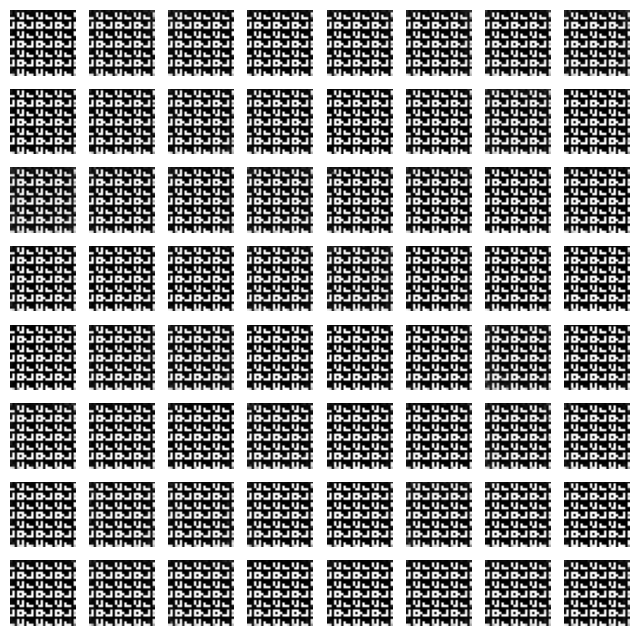

In [97]:
with torch.no_grad():
  #gen.eval()
  z=gen(128)
  z=z[:64]
  x = z.view(8, 8, 28, 28)
  x = x.to('cpu')
  image_np = x.numpy()

  # Create a figure and a set of subplots arranged in an 8x8 grid
  fig, axes = plt.subplots(8, 8, figsize=(8, 8))

  # Iterate through the subplots and display each image
  for i in range(8):
      for j in range(8):
          axes[i, j].imshow(image_np[i, j], cmap='gray')
          axes[i, j].axis('off')  # Turn off axis labels

  plt.show()

In [99]:
z=data[:128].to(Device)
y=disc(z)
y

tensor([1.0000, 1.0000, 0.9998, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.9999, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.9999, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        0.9999, 1.0000, 1.0000, 1.0000, 